<a href="https://colab.research.google.com/github/Userfound404/QML-HEP-GSOC-2023/blob/main/GsoC_task_6_Representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 6

In this task you should implement a simple representation learning scheme based on a contrastive loss:
- Load the MNIST dataset
- Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
- Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
- Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.




## Using PennyLane


In [1]:
!pip3 install --upgrade pip
!pip3 install tensorflow
!pip3 install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.3 MB/s eta 0:00:00


In [2]:

import tensorflow as tf
import pennylane as pl
import numpy as np
from tensorflow.keras.datasets import mnist

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd 'drive/MyDrive/Projects/GSOC'

/content/drive/MyDrive/Projects/GSOC


In [28]:
n_epochs = 30 
n_layers = 1  
n_train = 50  
n_test = 30    
n_wires = 4

SAVE_PATH = "/replearn"
PREPROCESS = True           
np.random.seed(0)           
tf.random.set_seed(0)  

In [7]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# Normalize pixel values within 0 and 1
x_train = x_train / 255
x_test = x_test / 255


11490434/11490434 [==============================] - 0s 0us/step


In [9]:
def q_circuit(params, x):
    pl.templates.AngleEmbedding(x, wires=range(4))
    pl.templates.StronglyEntanglingLayers(params, wires=range(4))
    return [pl.expval(pl.PauliZ(i)) for i in range(4)]

In [10]:
def swap_test_circuit(params, x1, x2):
    pl.Hadamard(wires=0)
    pl.CSWAP(wires=[0, 1, 2])
    pl.RY(params[0], wires=0)
    pl.RY(params[1], wires=1)
    pl.RY(params[2], wires=2)
    pl.CSWAP(wires=[0, 1, 2])
    pl.Hadamard(wires=0)
    return pl.expval(pl.PauliZ(0))

In [11]:
def contrastive_loss(y_true, y_pred, margin=1):
    loss = y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred)
    return tf.reduce_mean(loss)

In [12]:
device = pl.device("default.qubit", wires=4)

In [13]:

@pl.qnode(device, interface="tf")
def quantum_model(inputs, params):
    return q_circuit(params, inputs)

@pl.qnode(device, interface="tf")
def swap_test(inputs_1, inputs_2, params):
    return swap_test_circuit(params, inputs_1, inputs_2)
     

In [14]:
params = np.random.randn(10)  

In [22]:
def MyModel():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [24]:
model = MyModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1))

In [29]:
params = np.random.normal(loc=0, scale=0.1, size=(n_layers, n_wires))

In [30]:
q_model = MyModel()

q_history = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)

Epoch 1/10
15000/15000 - 58s - loss: 0.1981 - accuracy: 0.9410 - val_loss: 0.1101 - val_accuracy: 0.9675 - 58s/epoch - 4ms/step
Epoch 2/10
15000/15000 - 57s - loss: 0.0941 - accuracy: 0.9721 - val_loss: 0.0927 - val_accuracy: 0.9719 - 57s/epoch - 4ms/step
Epoch 3/10
15000/15000 - 53s - loss: 0.0686 - accuracy: 0.9787 - val_loss: 0.1062 - val_accuracy: 0.9688 - 53s/epoch - 4ms/step
Epoch 4/10
15000/15000 - 52s - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.0996 - val_accuracy: 0.9740 - 52s/epoch - 3ms/step
Epoch 5/10
15000/15000 - 58s - loss: 0.0471 - accuracy: 0.9859 - val_loss: 0.1031 - val_accuracy: 0.9720 - 58s/epoch - 4ms/step
Epoch 6/10
15000/15000 - 50s - loss: 0.0384 - accuracy: 0.9877 - val_loss: 0.0876 - val_accuracy: 0.9780 - 50s/epoch - 3ms/step
Epoch 7/10
15000/15000 - 53s - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.1024 - val_accuracy: 0.9771 - 53s/epoch - 4ms/step
Epoch 8/10
15000/15000 - 53s - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.1232 - val_accuracy: 0.9758

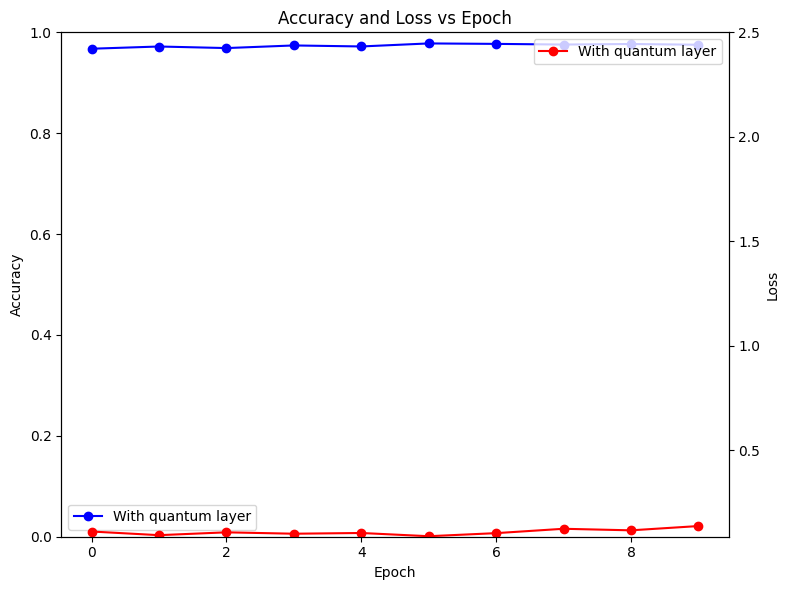

In [32]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-or", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.legend()

plt.title('Accuracy and Loss vs Epoch')
plt.tight_layout()
plt.show()